### Team members

##### Chirag Bhuvaneshwara
* 2571703
* s8chbhuv@stud.uni-saarland.de

##### Priyasha Chatterjee 
* 2572739
* s8prchat@stud.uni-saarland.de

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sounddevice as sd
from scipy.io import wavfile
import random

# 1.1 CapPhi & SmlPhi

In [80]:
def cap_phi(signal, order):
    
    p = order
    
    capPhiMat = np.zeros((p,p))
    for i in range(1, p+1):
        for j in range(1, p+1):
            
            sumOverSamples = 0
            for n in range(len(signal)):
                sumOverSamples += signal[n-i] * signal[n-j]
            
            capPhiMat[i-1,j-1] += sumOverSamples
    
    return capPhiMat

In [81]:
def sml_phi(signal, order):
    
    p = order
    
    smlPhiVec = np.zeros((p))
    for i in range(1, p+1):
                    
        sumOverSamples = 0
        for n in range(len(signal)):
            sumOverSamples += signal[n-i] * signal[n]

        smlPhiVec[i-1] += sumOverSamples
    
    return smlPhiVec
    

In [82]:
x = np.arange(1,10,1)
x

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [83]:
cap_phi(x, 6)

array([[285., 249., 222., 204., 195., 195.],
       [249., 285., 249., 222., 204., 195.],
       [222., 249., 285., 249., 222., 204.],
       [204., 222., 249., 285., 249., 222.],
       [195., 204., 222., 249., 285., 249.],
       [195., 195., 204., 222., 249., 285.]])

In [84]:
sml_phi(x, 6)

array([249., 222., 204., 195., 195., 204.])

# 1.2 Solve Linear System of Equations

In [85]:
def solve_coef(signal, order):
    
    capPhiMat = cap_phi(signal, order)
    smlPhiVec = sml_phi(signal, order)
    
    aVec = np.linalg.solve(capPhiMat, smlPhiVec)
    
    return aVec

In [86]:
solve_coef(x, 6)

array([ 0.73369565, -0.00652174, -0.00652174, -0.00652174, -0.00652174,
        0.23369565])

# 1.3 Record Sound

In [87]:
duration = 1  # seconds
fs = 48000
num_channels = 1

In [88]:
# myrecording_a = sd.rec(int(duration * fs), samplerate=fs, channels=num_channels)

In [89]:
# myrecording_l = sd.rec(int(duration * fs), samplerate=fs, channels=num_channels)

In [90]:
# myrecording_m = sd.rec(int(duration * fs), samplerate=fs, channels=num_channels)

In [91]:
# myrecording_a = myrecording_a[8000:]
# myrecording_l = myrecording_l[8000:]
# myrecording_m = myrecording_m[8000:]

In [92]:
f1 = "signals/a.wav"
f2 = "signals/l.wav"
f3 = "signals/m.wav"
rate = 40000

In [93]:
# wavfile.write(f1, rate, myrecording_a)
# wavfile.write(f2, rate, myrecording_l)
# wavfile.write(f3, rate, myrecording_m)

In [94]:
_, myrecording_a = wavfile.read(f1)
_, myrecording_l = wavfile.read(f2)
_, myrecording_m = wavfile.read(f3)

In [95]:
sd.play(myrecording_a, fs)

In [96]:
sd.play(myrecording_l, fs)

In [97]:
sd.play(myrecording_m, fs)

In [98]:
a_aVals = solve_coef(myrecording_a, 10)
l_aVals = solve_coef(myrecording_l, 10)
m_aVals = solve_coef(myrecording_m, 10)

# 1.4 Portion and Predict

In [99]:
def portionAndPredict(portionOfSignal, coefficientVec):
    
    revSig = np.flip(portionOfSignal)
    
    nextValue = 0
    for j in range(len(coefficientVec)):

        nextValue += revSig[j] * coefficientVec[j]

  
    return nextValue

In [100]:
a = solve_coef(x, 1)
a

array([0.87368421])

In [101]:
portionAndPredict(np.flip(x[:-1]), a)

0.8736842105263158

In [102]:
x[-1]

9

# 1.5 Find Error Signal

In [103]:
def findErrorSignal(signal, coefVec):
    
    errorSignal = np.zeros((len(signal)))
    
    for i in range(len(errorSignal)):
        
        if i < len(coefVec):
            errorSignal[i] = 0
        
        else:
            pred = portionAndPredict(signal[:i],coefVec)
            errorSignal[i] = signal[i] - pred
    
    return errorSignal

In [104]:
e = findErrorSignal(x[:-1], a)
e

array([0.        , 1.12631579, 1.25263158, 1.37894737, 1.50526316,
       1.63157895, 1.75789474, 1.88421053])

In [105]:
error_a = findErrorSignal(myrecording_a, a_aVals)
error_l = findErrorSignal(myrecording_l, l_aVals)
error_m = findErrorSignal(myrecording_m, m_aVals)

# 2.1 Reconstruct

In [106]:
def reconstruct_n(portionOfSignal, coefVec, errorSignalElement):
    
    predSignalPoint = portionAndPredict(portionOfSignal, coefVec)    
    predSignalPoint += errorSignalElement
    
    return predSignalPoint     

In [107]:
reconstruct_n(x[:-1], a, e[-1])

8.873684210526315

In [108]:
x[-1]

9

# 2.2 Reconstruct Whole Signal

In [109]:
def reconstruct_whole_signal(basicInputSignal, coefVec, errorSignal, numTotalSamples=40000):
    
    numInputPoints = len(basicInputSignal)
    
    zeros = np.zeros(numTotalSamples - numInputPoints)
    predSignal = np.append(basicInputSignal, zeros)
    
    for sNum in range(numInputPoints, numTotalSamples):
        prevSignal = predSignal[:sNum]
        errorSignalElement = errorSignal[sNum]
        
        predSignal[sNum] += reconstruct_n(prevSignal, coefVec, errorSignalElement)
    

        
    return predSignal
        

In [113]:
x = np.arange(100,1,-3)
x = np.random.normal(scale = 1.0, size=40000)

n =7
a = solve_coef(x,6)

basicInputSignal = x[:10]
e = findErrorSignal(x, a)
np.sum(x-reconstruct_whole_signal(basicInputSignal, a, e, x.shape[0]))

-2.8010786642636634e-15

## Reconstructing and plotting our recordings

In [174]:
basicInputSignal = myrecording_a[:10]
reconst_a = reconstruct_whole_signal(basicInputSignal, a_aVals, error_a)
sd.play(reconst_a, fs)

In [175]:
basicInputSignal = myrecording_l[:10]
reconst_l = reconstruct_whole_signal(basicInputSignal, l_aVals, error_l)
sd.play(reconst_l, fs)

In [176]:
basicInputSignal = myrecording_m[:10]
reconst_m = reconstruct_whole_signal(basicInputSignal, m_aVals, error_m)
sd.play(reconst_m, fs)

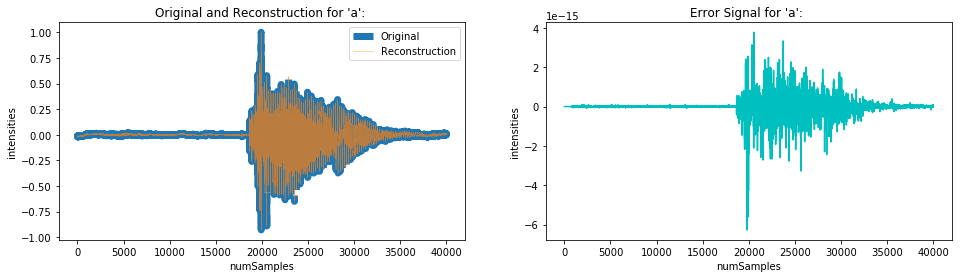

In [187]:
fig=plt.figure(figsize=(16, 4))

columns = 2
rows = 1

ax1 = plt.subplot(rows, columns, 1)
ax1.set_title("Original and Reconstruction for 'a': ")
ax1.plot(np.arange(0,40000), myrecording_a, linestyle="dashdot", label = "Original", linewidth = 7)
ax1.plot(np.arange(0,40000), reconst_a, label="Reconstruction", alpha = 0.7, linewidth = 0.5)
ax1.legend(loc="upper right")
plt.xlabel('numSamples')
plt.ylabel('intensities')

ax2 = plt.subplot(rows, columns, 2)
ax2.set_title("Error Signal for 'a': ")
ax2.plot(np.arange(0,40000), myrecording_a-reconst_a, color='c')
plt.xlabel('numSamples')
plt.ylabel('intensities')

plt.show()

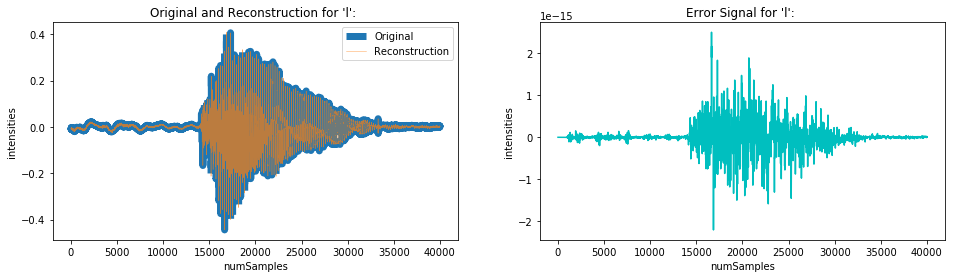

In [188]:
fig=plt.figure(figsize=(16, 4))

columns = 2
rows = 1

ax1 = plt.subplot(rows, columns, 1)
ax1.set_title("Original and Reconstruction for 'l': ")
ax1.plot(np.arange(0,40000), myrecording_l, linestyle="dashdot", label = "Original", linewidth = 7)
ax1.plot(np.arange(0,40000), reconst_l, label="Reconstruction", alpha = 0.7, linewidth = 0.5)
ax1.legend(loc="upper right")
plt.xlabel('numSamples')
plt.ylabel('intensities')

ax2 = plt.subplot(rows, columns, 2)
ax2.set_title("Error Signal for 'l': ")
ax2.plot(np.arange(0,40000), myrecording_l-reconst_l, color='c')
plt.xlabel('numSamples')
plt.ylabel('intensities')

plt.show()

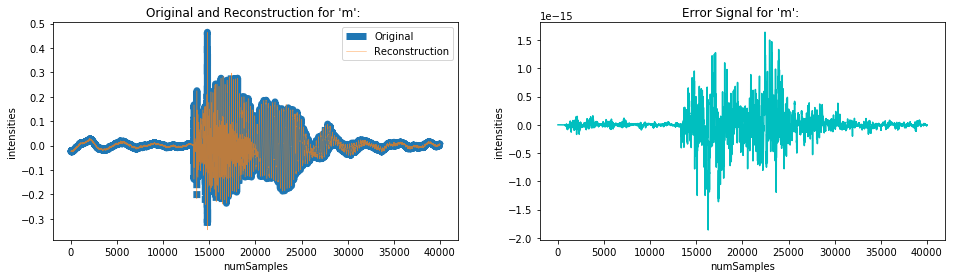

In [189]:
fig=plt.figure(figsize=(16, 4))

columns = 2
rows = 1

ax1 = plt.subplot(rows, columns, 1)
ax1.set_title("Original and Reconstruction for 'm': ")
ax1.plot(np.arange(0,40000), myrecording_m, linestyle="dashdot", label = "Original", linewidth = 7)
ax1.plot(np.arange(0,40000), reconst_m, label="Reconstruction", alpha = 0.7, linewidth = 0.5)
ax1.legend(loc="upper right")
plt.xlabel('numSamples')
plt.ylabel('intensities')

ax2 = plt.subplot(rows, columns, 2)
ax2.set_title("Error Signal for 'm': ")
ax2.plot(np.arange(0,40000), myrecording_m-reconst_m, color='c')
plt.xlabel('numSamples')
plt.ylabel('intensities')

plt.show()